Name:  **Your name here**  
UID:  **Your student ID num here**

# Homework 7:  Splitting Methods 
### Due May 14, 2019
Upload **both** your notebook (a file with extension "ipynb") **and** a pdf version of your notebook to [ELMS](https://umd.instructure.com/courses/1255897). 

Put the file `notebook_importer.py` into your directory, along with `utility.py` from homework 6.  Then run the following cell.

In [1]:
import notebook_importer
from utility import *
import numpy as np
from numpy import sqrt, sum, abs, sign, max, maximum, minimum, logspace, exp, log, log10, zeros
from numpy.linalg import norm
from numpy.random import randn, rand, normal, randint
import urllib
import matplotlib.pyplot as plt

np.random.seed(0)
def good_job(path):
    a = plt.imread(urllib.request.urlopen(path))
    fig = plt.imshow(a)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()
np.random.seed(0)

running importer
importing Jupyter notebook from utility.ipynb
Founds 7 cells


# Problem 1: FBS
Write a method that uses FBS to solve a general problem of the form 
$$\min \quad f(x)+g(x),$$
where $f$ is smooth and $g$ is simple.
You can do this by building on your gradient descent code from homework 2.  
The argument $f$ computes the scalar-valued function $f(x).$  The argument `gradf` is a function handle that computes the gradient of $f.$  This means that
 $$ \mathtt{gradf}(x) = \nabla f(x).$$ 
  The argument `proxg` is a function handle that computes the proximal operator of $g$ with stepsize $\tau.$  This means that 
  $$proxg(z,\tau) = \arg \min_x  g(x) + \frac{1}{2\tau}\|x-z\|^2.$$
  Your method should start by estimating the initial stepsize $\tau$ using the Lipschitz constant for the gradient of $f.$  You already did this in homework 5 in your gradient descent method. The method should then perform an iteration of FBS, and use a backtracking line search until the following condition is met:
      $$f(x^{k+1}) \le f(x^k)+\langle x^{k+1}-x^k, \nabla f(x^k) \rangle + \frac{1}{2\tau}\|x^k-x^{k+1}\|^2.$$

Your method should terminate when the residual
   $\frac{1}{\tau}\|x^{k+1}-x^k\|$
   is "small" according to some reasonable criteria.  Formulas for the line search and residuals can be found in the paper "A field guide to forward backward splitting with a FASTA implementation," (the line search condition is discussed in section 4.4, and formulas for the residuals are in section 4.6)  and also in the lecture slides.
   
  Your method should return an array containing the solution to the problem.


In [2]:
def estimate_lipschitz(g, x):
    # Your work here
    y = x + np.random.normal(size=x.shape)
    L = np.linalg.norm(g(x) - g(y))/ np.linalg.norm(x-y)
    return L

In [3]:
def  fbs(f, gradf, proxg, x0, max_iters = 10000, tol=1e-6):
    ## Your work here! 
    converged = False
    step_size = 10 / estimate_lipschitz(gradf,x0)
    x = x0
    while(max_iters and not converged):
        max_iters -=1
        gradient = gradf(x)        
        x_n = proxg(x - step_size * gradient, step_size)
        while(f(x_n) > (f(x) + np.vdot(x_n - x, gradient) + (0.5/step_size)*(np.linalg.norm(x_n - x))**2 )):
            step_size /= 2.
            x_n = proxg(x - step_size * gradient, step_size)
            
        if(np.linalg.norm(x_n - x)/step_size < tol):
            converged = True

        x = x_n
    return x


### Now, run this unit test

In [4]:
# Minimizer f+g where f(x)=.5(x+2)^2, g(x)=.5(x)^2
f = lambda x: 0.5*(x-2)**2
gradf = lambda x: x-2
g = lambda x: 0.5*x**2
proxg = lambda z,t: z/(1+t)
x0 = np.array(5)

x = fbs(f,gradf,proxg,x0)
assert abs(x-1)<1e-4, "Your solution is not accurate enough!"
print('Your FBS solver worked!')

Your FBS solver worked!


### Now let's cook up a sparse least squares problem 

In [5]:
# Don't modify this block!
A = randn(100,200)
x_true = zeros((200,1))
x_true[0:10] = 1
b = A@x_true
mu = 10

### Use your FBS solver to solve the problem
$$\arg \min \quad  \mu|x| + \frac{1}{2}\|Ax-b\|^2$$


In [15]:
def shrink(z,t):
    x = sign(z)* np.fmax(abs(z) - t,0);
    return x

print(shrink(np.array([3,5,2]),5))

[0 0 0]


In [16]:
# Fill out the implementations of these methods. I suggest using lambda functions to keep it short
f = lambda x: 0.5*np.linalg.norm(A@x-b)**2 # your work here
gradf = lambda x: A.T@(A@x - b) # your work here
g = lambda x: mu * np.linalg.norm(x,ord=1) # your work here
proxg = lambda z,t: shrink(z,mu*t) # your work here

### Now, run this method to call the solver and test results

TEST PASSED! Wow! You are so in the zone right now!


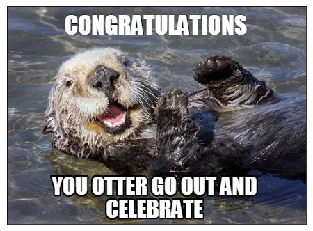

In [17]:
# %%pixie_debugger
x0 = zeros((200,1))
x = fbs(f,gradf,proxg,x0, tol=1e-8) # Note: I use super high accuracy here so that my unit best below works
# Test that your solution satisfies the optimality condition for the problem
g = gradf(x)
assert max(abs(g[x==0])) <= mu+1e-4, "Your solution is incorrect"
assert norm(g[x!=0] + mu*sign(x[x!=0]))/norm(g[x!=0]) < 1e-4,  "Your solution is incorrect"
print('TEST PASSED! Wow! You are so in the zone right now!')
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/otter.png")

# Problem 2: ADMM
In this problem,
you'll write an "unwrapped ADMM" solver for the support-vector machine problem
$$
 \min \quad \frac{1}{2} \|x\|^2+Ch(Ax)
$$ 
where $h(z) = \sum_i \max\{1-z_i,0\}$ is the hinge loss function, and  $A = YX$ is the product of the (diagonal) label matrix with the data matrix.  Your solver will be based on the constrained formulation

\begin{align}
 \min &\quad \frac{1}{2} \|x\|^2+Ch(y)\\
 \text{subject to}&\quad   y=Ax.
\end{align}

Start by running the block below to produce a test problem.

In [ ]:
# Define a classification problem
X, y = create_classification_problem(100, 10, cond_number=10)
A = y*X
t = 1/norm(A.T@A)
C = 1

### Write the scaled augmented Lagrangian for the constrained problem
 Use $\lambda$ to donote the Lagrange multiplier.
 
 **Your solution here**

### Write the system of equations that needs to be solved to update $x$
 **Your solution here**

### Write a routine to evaluate the prox operator of the hinge loss. Your routine will return the solution to the prox problem
$$\text{prox}_h(z,t) = \arg\min_x h(x) + \frac{1}{2t}\|x-z\|^2.$$
You cannot use an iterative method to compute this value.  Note: this can be done with one line of code.  The prox operator for the hinge loss is a lot like the prox operator for L1.

In [ ]:
def hprox(z,t):
    # Your work here
    return x

### Now run these unit tests

In [ ]:
assert hprox(0,1)==1, "Your prox operator failed unit test 1"
assert hprox(1,1)==1, "Your prox operator failed unit test 2"
assert hprox(-1,1)==0, "Your prox operator failed unit test 3"
assert hprox(1,2)==1, "Your prox operator failed unit test 4"
assert hprox(1,3)==1, "Your prox operator failed unit test 5"
assert hprox(4,3)==4, "Your prox operator failed unit test 6"

### Write an ADMM loop to solve the SVM problem above.  
Use your prox operator for the $y$ update.
Run the solver until the primal and dual residuals satisfy
$$p^k \le 10^{-5} \max_{i<k}p^i$$
$$d^k \le 10^{-5} \max_{i<k}d^i.$$
The residuals are given by 
$$p^k = \|Ax^k-y^k\|$$
$$d^k = \|\tau A^T(y^k-y^{k-1})\|.$$

In [ ]:
x = zeros((10,1))
y = zeros((100,1))
l = zeros((100,1))

# Your work below


### Now run this unit test

In [ ]:
assert norm(x+t*A.T@(A@x-y-l))/norm(x)<1e-3, 'Your ADMM solver did not produce an accurate solution.'
z = A@x-l
assert norm(y-z - maximum(minimum(1-z,C/t),0))/norm(y)<1e-3, 'Your ADMM solver did not produce an accurate solution.'
print('Congrats! Your solver works!!')
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/ron_awesome.png")